In [366]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from numpy import convolve
from sklearn.model_selection import train_test_split
import numpy as np
from fbprophet import Prophet
import datetime as dt

In [367]:
def plot_crypto(coin): # retrieve 1 cryptocurrency via API and plot
    base = "http://api.coingecko.com/api/v3/coins/"
    url = base + coin + "/market_chart?vs_currency=usd&days=300"

    result = requests.get(url)
    j = result.json()

    coin_df = pd.DataFrame(j['prices'], columns = ['date','price'])
    coin_df['date'] = pd.to_datetime(coin_df['date'],unit = 'ms').dt.round('1min') # convert to date time formatting

    coin_df.plot('date','price')
    plt.show()
    return coin_df

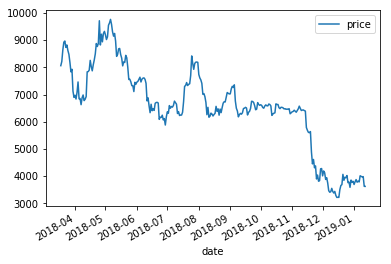

In [368]:
bitcoin_df = plot_crypto(coin = 'bitcoin')

In [369]:
def plot_pred(coin_df):
    a = coin_df.head(10)
    a['x-1'] = a['price'].shift(1) #shifts a down by 1 replace by NaN
    a['x-2'] = a['price'].shift(2)
    a['x-3'] = a['price'].shift(3) #target value is now associated with period 1, 2, 3 before

    a.dropna(inplace=True)

    X = a[['x-1','x-2','x-3']]
    y = a['price']

    m = LinearRegression()

    m.fit(X,y)

    print('Prediction Score: ' + str(round(m.score(X,y),2)*100) + '%')
    ypred = m.predict(X)

    a['ypred'] = pd.DataFrame(ypred)

    a.plot('date','ypred')
    a.plot('date','price')
    plt.show()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

Prediction Score: 69.0%


/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


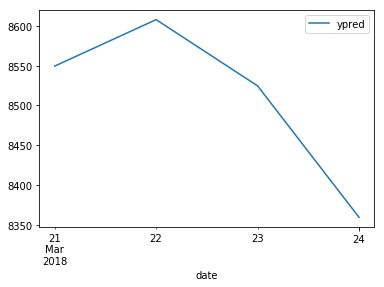

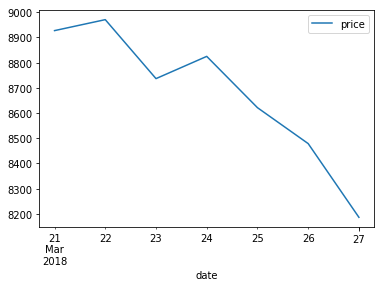

In [370]:
plot_pred(bitcoin_df)

In [371]:
bitcoin_df.set_index(['date'],inplace=True)

In [372]:
def plot_autocorrelation(coin_df):
    coin_df.set_index(['date'],inplace=True)
    plot_acf(coin_df,  alpha=.05, use_vlines=True)     # Confidence intervals are drawn as a cone
    """By default set to a 95% confidence interval, suggesting that correlation values 
    outside cone are very likely a correlation and not a statistical fluke"""

In [373]:
url_list = "https://api.coingecko.com/api/v3/coins/list" # get list of coins from API
coin_list = requests.get(url_list).json()
coin_list = pd.DataFrame(coin_list)
coins = coin_list['id'][0:11]

In [374]:
coins

0          bitcoin
1         litecoin
2       auroracoin
3         peercoin
4         dogecoin
5              nxt
6             omni
7         namecoin
8     counterparty
9            quark
10     feathercoin
Name: id, dtype: object

In [309]:
def import_coin_data(coins_list):
    data_list = []

    for i in coins_list: 
        base = "http://api.coingecko.com/api/v3/coins/"
        url = base + i + "/market_chart?vs_currency=usd&days=300"
        result = requests.get(url)
        data = result.json()
        data_df = pd.DataFrame(data['prices'], columns = ['date','price'])
        data_df["file_name"] = i
        data_list.append(data_df)
    
    coins_df = pd.concat(data_list)
    coins_df['date'] = pd.to_datetime(data_df['date'],unit = 'ms').dt.round('1min')
    coins_df.rename(columns={'file_name': 'coin'},inplace=True)
    coins_df.set_index(['coin'])
        
    return coins_df

In [310]:
coins_df = import_coin_data(coins)

In [311]:
def plot_cryptio_time_series(coin_list, coins_df): # plot 10 cryptocurrency time series
    for i in coin_list:
        individual = coins_df[coins_df.coin == i]
        plt.plot(individual['date'], individual['price'], label = i)
        plt.legend()
        plt.title('coins over time')
        plt.ylabel('price')
        plt.xlabel('year')
        plt.xticks(rotation='vertical')

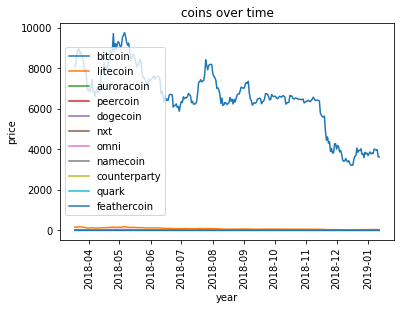

In [312]:
plot_cryptio_time_series(coins, coins_df)

In [313]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [314]:
def plot_rolling_avg(coin_list, coins_df):
    for i in coin_list:
        individual = coins_df[coins_df.coin == i]
        yMA = movingaverage(individual['price'],5)
        plt.plot(individual['date'][len(individual['date'])-len(yMA):], yMA, label = i)
        plt.legend()
        plt.title('coins over time')
        plt.ylabel('price')
        plt.xlabel('year')
        plt.xticks(rotation='vertical')

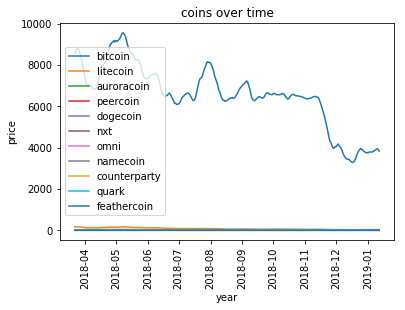

In [315]:
plot_rolling_avg(coins, coins_df)

In [333]:
def plot_rolling_coin_regression(coins_df, dist_roll, coin_name, num_degrees):
    coin_indiv = coins_df[coins_df.coin == coin_name]
    del coin_indiv['coin']
            
    coin_indiv['date']=coin_indiv['date'].map(dt.datetime.toordinal)
    coin_indiv.reset_index(inplace=True)
    coin_indiv['p-mean'] = coin_indiv['price'].rolling(dist_roll).mean()
    coin_indiv = coin_indiv.dropna()

    x = coin_indiv['date']
    X = np.array(x)
    X = X.reshape(-1,1)
    
    y = coin_indiv['price']
    y = np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)
    
    # Linear Regression
    
    m = LinearRegression()
    m.fit(X_train,y_train)
    print('Linear Regression Train score: ' + str(round(m.score(X_train,y_train),2)*100) + '%')
    print('Linear Regression Test score: ' + str(round(m.score(X_test,y_test),2)*100) + '%')
    
    ypred = m.predict(X_test)
    
    x_g = coin_indiv['date']
    y_g= coin_indiv['price']
    
    #Polynomial Regression
    
    PolyReg = PolynomialFeatures(degree = num_degrees)
    Xpoly = PolyReg.fit_transform(X)
    
    Xpoly_train, Xpoly_test, ypoly_train, ypoly_test = train_test_split(Xpoly,y, random_state = 42)
    
    PolyReg.fit(Xpoly_train, ypoly_train)
    m.fit(Xpoly_train, ypoly_train)
    
    print('Polynomial Regression Train score: ' + str(round(m.score(Xpoly_train,ypoly_train),2)*100) + '%')
    print('Polynomial Regression Test score: ' + str(round(m.score(Xpoly_test,ypoly_test),2)*100) + '%')
    
    ypred_poly = m.predict(PolyReg.fit_transform(X_test))
    
    # Lasso Normalization
    
    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(Xpoly_train)
    scaled_x_test = scaler.fit_transform(Xpoly_test)
    Lasso_fit = Lasso(alpha = 0.001).fit(scaled_x,ypoly_train)

    print('Lasso Train score: ' + str(round(Lasso_fit.score(scaled_x,ypoly_train),2)*100) + '%')
    print('Lasso Test score: ' + str(round(Lasso_fit.score(scaled_x_test,ypoly_test),2)*100) + '%')
    
    ypred_poly_lasso = Lasso_fit.predict(scaler.fit_transform(PolyReg.fit_transform(X_test)))
    
    # Ridge Normalization
    
    Ridgefit = Ridge(alpha = 0.0000001).fit(scaled_x,ypoly_train)
    
    print('Ridge Train score: ' + str(round(Ridgefit.score(scaled_x,ypoly_train),2)*100) + '%')
    print('Ridge| Test score: ' + str(round(Ridgefit.score(scaled_x_test,ypoly_test),2)*100) + '%')

    ypred_Rid = Rid_fit.predict(scaler.fit_transform(PolyReg.fit_transform(X_test)))
    
    plt.scatter(x_g,y_g,color = 'b',s = 0.15)
    plt.plot(X_test,ypred, 'r--')
    plt.plot(X,m.predict(PolyReg.fit_transform(X)),'b--')
    plt.plot(X, Lasso_fit.predict(scaler.fit_transform(PolyReg.fit_transform(X))),'g--')
    plt.plot(X,Ridgefit.predict(scaler.fit_transform(PolyReg.fit_transform(X))),'k:')
    plt.legend(['LinReg','PolyReg','Lasso','Ridge'])
    plt.ylabel('price')
    plt.xlabel('date')
    plt.show()
    
    # visualize alpha for ridge
    coeff = []
    param = np.linspace(0.0000001,100,20)

    for i in np.linspace(0.0000001,100,20):
        Ridgefit = Ridge(alpha = i).fit(scaled_x,ypoly_train)
        coeff.append(Ridgefit.score(scaled_x,ypoly_train))
        i += 1

    plt.plot(param,coeff)
    plt.ylabel('coef')
    plt.title('Accuracy over Regularization strength -Ridge')
    plt.xlabel('param')
    plt.show()
    
    # visualize alpha for lasso
    coeff2 = []
    param2 = np.linspace(0.0000000001,0.01,10)

    for i in np.linspace(0.0000000001,0.01,10):
        Lasso_fit = Lasso(alpha = i).fit(scaled_x,ypoly_train)
        coeff2.append(Lasso_fit.score(scaled_x,ypoly_train))
        i += 1

    plt.plot(param2,coeff2)
    plt.ylabel('coef')
    plt.title('Accuracy over Regularization strength -Lasso')
    plt.xlabel('param')
    plt.show()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision

Linear Regression Train score: 68.0%
Linear Regression Test score: 65.0%
Polynomial Regression Train score: 73.0%
Polynomial Regression Test score: 74.0%
Lasso Train score: 68.0%
Lasso Test score: 65.0%
Ridge Train score: 73.0%
Ridge| Test score: 73.0%


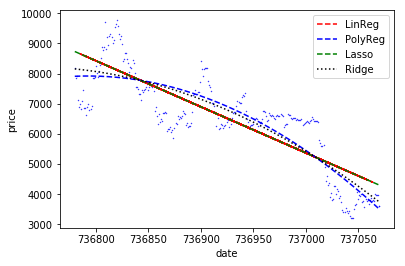

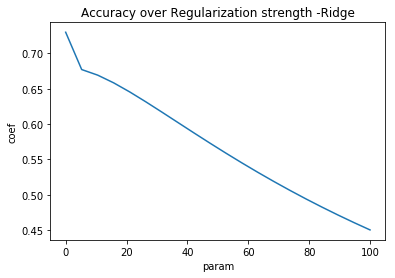

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:4

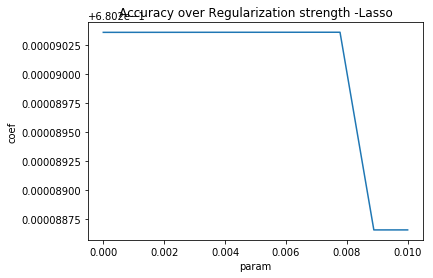

In [334]:
plot_rolling_coin_regression(coins_df, dist_roll=10, coin_name = 'bitcoin', num_degrees = 4)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Linear Regression Train score: 79.0%
Linear Regression Test score: 80.0%
Polynomial Regression Train score: 90.0%
Polynomial Regression Test score: 90.0%
Lasso Train score: 79.0%
Lasso Test score: 80.0%
Ridge Train score: 89.0%
Ridge| Test score: 89.0%


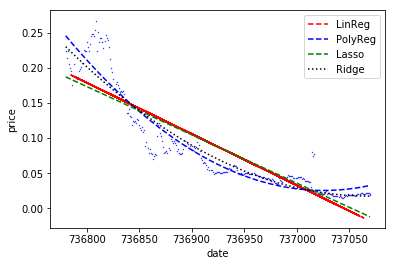

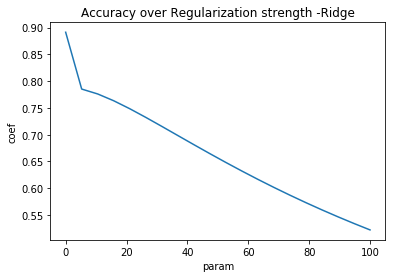

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


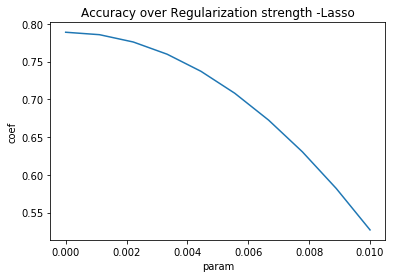

In [335]:
plot_rolling_coin_regression(coins_df, dist_roll=10, coin_name = 'feathercoin', num_degrees = 4)

In [363]:
def predict_w_prophet(coins_df, coin_name, dist_roll, periods, freq): # value prediction with prophet
    coin_indiv = coins_df[coins_df.coin == coin_name] # take data for specific coin
    coin_indiv['p-mean'] = coin_indiv['price'].rolling(dist_roll).mean() # take rolling avg over specificed time frame
    coin_indiv = coin_indiv.dropna()
    coin_indiv = coin_indiv.rename(columns={'date':'ds', 'p-mean':'y'})
    
    m = Prophet(weekly_seasonality=True)
    m.fit(coin_indiv)
    
    future = m.make_future_dataframe(periods = periods, freq = freq)
    forecast = m.predict(future)
    
    m.plot(forecast)
    plt.title(coin_name +' Forecast')
    plt.ylabel('price')
    plt.xlabel('date');

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


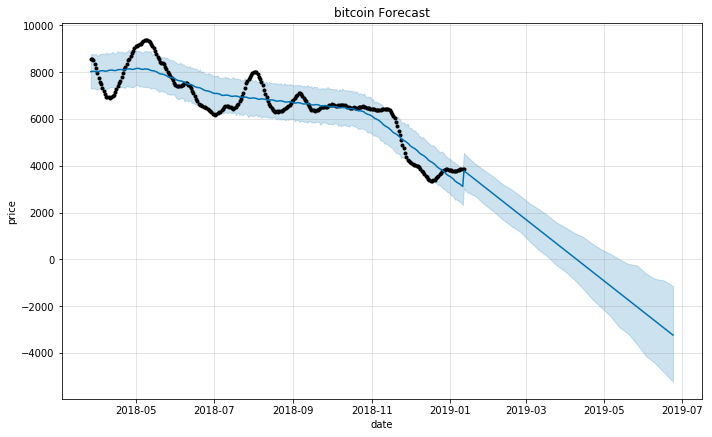

In [364]:
predict_w_prophet(coins_df, coin_name = 'bitcoin', dist_roll =10, periods = 24, freq = 'W')

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


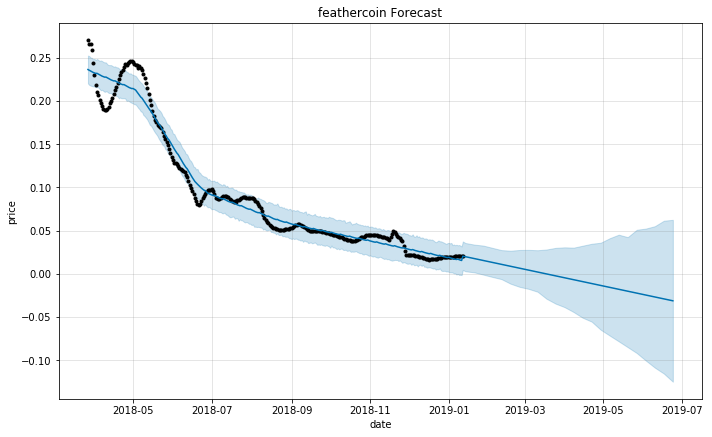

In [365]:
predict_w_prophet(coins_df, coin_name = 'feathercoin', dist_roll =10, periods = 24, freq = 'W')